In [1]:
from time import time
from discopy import disco, config, Pregroup, Word
config.fast = True

s, n = Pregroup('s'), Pregroup('n')
Alice = Word('Alice', n)
loves = Word('loves', n.r @ s @ n.l)
Bob =  Word('Bob', n)
who = Word('who', n.r @ n @ s.l @ n)
is_rich = Word('is rich', n.r @ s)

vocab = [Alice, loves, Bob, who, is_rich]

In [2]:
gen, n_sentences = disco.brute_force(*vocab), 20
sentences, parsing = list(), dict()

print("Brute force search for grammatical sentences:")

start = time()
for i in range(n_sentences):
    diagram = next(gen)
    sentence = ' '.join(str(w)
        for w in diagram.boxes if isinstance(w, Word)) + '.'
    sentences.append(sentence)
    parsing.update({sentence: diagram})
    print(sentence)

print("{:.2f} seconds to generate {} sentences.\n".format(time() - start, n_sentences))

print("Diagram for 'Alice who loves Bob is rich.':")
_print = lambda diagram: print(str(diagram).replace('>>', '\n>>'))
_print(parsing['Alice who loves Bob is rich.'])

Brute force search for grammatical sentences:
Alice is rich.
Bob is rich.
Alice loves Alice.
Alice loves Bob.
Bob loves Alice.
Bob loves Bob.
Alice who is rich is rich.
Bob who is rich is rich.
Alice who loves Alice is rich.
Alice who loves Bob is rich.
Alice who is rich loves Alice.
Alice who is rich loves Bob.
Bob who loves Alice is rich.
Bob who loves Bob is rich.
Bob who is rich loves Alice.
Bob who is rich loves Bob.
Alice who loves Alice loves Alice.
Alice who loves Alice loves Bob.
Alice who loves Bob loves Alice.
Alice who loves Bob loves Bob.
5.51 seconds to generate 20 sentences.

Diagram for 'Alice who loves Bob is rich.':
Alice 
>> Wire(n) @ who 
>> Wire(n @ n.r @ n @ s.l @ n) @ loves 
>> Wire(n @ n.r @ n @ s.l @ n @ n.r @ s @ n.l) @ Bob 
>> Wire(n @ n.r @ n @ s.l @ n @ n.r @ s @ n.l @ n) @ is rich 
>> Cup(n, n.r) @ Wire(n @ s.l @ n @ n.r @ s @ n.l @ n @ n.r @ s) 
>> Wire(n @ s.l) @ Cup(n, n.r) @ Wire(s @ n.l @ n @ n.r @ s) 
>> Wire(n) @ Cup(s.l, s) @ Wire(n.l @ n @ n.r @ s

In [3]:
from discopy import CircuitModel
from discopy.gates import sqrt, Ket, Id, H, Rx, CX, SWAP

GHZ = sqrt(2) @ Ket(0, 0, 0)\
    >> Id(1) @ H @ Id(1)\
    >> Id(1) @ CX\
    >> (SWAP >>  CX) @ Id(1)

print(GHZ.eval())

Matrix(dom=Dim(1), cod=Dim(2, 2, 2), array=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])


In [4]:
import numpy as np

def intransitive_ansatz(phase):
    return Ket(0) >> Rx(phase)

def transitive_ansatz(phase):
    return sqrt(2) @ Ket(0, 0) >> H @ Rx(phase) >> CX

ob = {s: 0, n: 1}
ar = lambda params: {
    Alice: Ket(0),
    loves: transitive_ansatz(params['loves']),
    Bob: Ket(1),
    who: GHZ,
    is_rich: intransitive_ansatz(params['is_rich'])}

F = lambda params: CircuitModel(ob, ar({'loves': params[0], 'is_rich': params[1]}))

params0 = np.array([0.5, 1.])
print("Circuit for 'Alice who loves Bob is rich.':")
_print(F(params0)(parsing['Alice who loves Bob is rich.']))

Circuit for 'Alice who loves Bob is rich.':
Ket(0) 
>> Id(1) @ sqrt(2) 
>> Id(1) @ Ket(0, 0, 0) 
>> Id(2) @ H @ Id(1) 
>> Id(2) @ CX 
>> Id(1) @ SWAP @ Id(1) 
>> Id(1) @ CX @ Id(1) 
>> Id(4) @ sqrt(2) 
>> Id(4) @ Ket(0, 0) 
>> Id(4) @ H @ Id(1) 
>> Id(5) @ Rx(0.5) 
>> Id(4) @ CX 
>> Id(6) @ Ket(1) 
>> Id(7) @ Ket(0) 
>> Id(7) @ Rx(1.0) 
>> CX @ Id(6) 
>> H @ sqrt(2) @ Id(7) 
>> Bra(0, 0) @ Id(6) 
>> Id(1) @ CX @ Id(3) 
>> Id(1) @ H @ sqrt(2) @ Id(4) 
>> Id(1) @ Bra(0, 0) @ Id(3) 
>> Id(1) @ CX @ Id(1) 
>> Id(1) @ H @ sqrt(2) @ Id(2) 
>> Id(1) @ Bra(0, 0) @ Id(1) 
>> CX 
>> H @ sqrt(2) @ Id(1) 
>> Bra(0, 0)


In [5]:
BornRule = lambda c: abs(c.eval().array) ** 2
evaluate = lambda F, sentence: BornRule(F(parsing[sentence]))

epsilon = 1e-2

print("True sentences:\n{}\n".format('\n'.join(sentence
    for sentence in sentences if evaluate(F(params0), sentence) > 1 - epsilon)))
print("False sentences:\n{}".format('\n'.join(sentence
    for sentence in sentences if evaluate(F(params0), sentence) < epsilon)))

True sentences:
Alice is rich.
Alice loves Bob.
Bob loves Alice.
Alice who is rich is rich.
Alice who loves Bob is rich.
Alice who is rich loves Bob.
Alice who loves Bob loves Bob.

False sentences:
Bob is rich.
Alice loves Alice.
Bob loves Bob.
Bob who is rich is rich.
Alice who loves Alice is rich.
Alice who is rich loves Alice.
Bob who loves Alice is rich.
Bob who loves Bob is rich.
Bob who is rich loves Alice.
Bob who is rich loves Bob.
Alice who loves Alice loves Alice.
Alice who loves Alice loves Bob.
Alice who loves Bob loves Alice.


In [6]:
from sklearn.model_selection import train_test_split

sentence_train, sentence_test = train_test_split(sentences, test_size=0.25, random_state=42)

print("Training set:\n{}\n".format('\n'.join(sentence_train)))
print("Testing set:\n{}".format('\n'.join(map(str, sentence_test))))

Training set:
Bob loves Bob.
Alice who is rich loves Bob.
Alice loves Bob.
Alice who loves Bob loves Alice.
Alice who loves Alice loves Alice.
Bob who loves Bob is rich.
Alice loves Alice.
Alice who loves Bob is rich.
Alice who loves Bob loves Bob.
Bob loves Alice.
Bob who loves Alice is rich.
Bob who is rich is rich.
Alice who is rich loves Alice.
Bob who is rich loves Alice.
Alice who is rich is rich.

Testing set:
Alice is rich.
Alice who loves Alice loves Bob.
Bob who is rich loves Bob.
Bob is rich.
Alice who loves Alice is rich.


In [7]:
from random import random, seed; seed(420)

corpus = {sentence: evaluate(F(params0), sentence) for sentence in sentences}

def training_loss(params):
    return np.mean(np.array([
        (corpus[sentence] - evaluate(F(params), sentence)) ** 2
        for sentence in sentence_train]))

def testing_loss(params):
    return np.mean(np.array([
        (corpus[sentence] - evaluate(F(params), sentence)) ** 2
        for sentence in sentence_test]))

params = np.array([random(), random()])

print("Random initialisation: {}".format(params))
print("Initial training loss: {}".format(training_loss(params)))
print("Initial testing loss: {}".format(testing_loss(params)))

print("\nIs Alice who loves Bob rich?")
print("Yes, she is."
      if evaluate(F(params), 'Alice who loves Bob is rich.') > 1 - epsilon
      else "No, she isn't.")

Random initialisation: [0.02634338 0.78136906]
Initial training loss: 0.5902112319721139
Initial testing loss: 0.1670995419006796

Is Alice who loves Bob rich?
No, she isn't.


In [8]:
from scipy.optimize import minimize

start, M = time(), minimize(training_loss, params)
print("{:.0f} seconds to converge to optimal parameters: {}".format(time() - start, M.x))
print("Final training loss: {}".format(training_loss(M.x)))
print("Final testing loss: {}".format(testing_loss(M.x)))
print()
print("Is Alice who loves Bob rich?")
print("Yes, she is."
      if evaluate(F(M.x), 'Alice who loves Bob is rich.') > 1 - epsilon
      else "No, she isn't.")

8 seconds to converge to optimal parameters: [0.50264689 0.998852  ]
Final training loss: 4.154755296026918e-09
Final testing loss: 1.9799430044293663e-09

Is Alice who loves Bob rich?
Yes, she is.


In [9]:
from discopy import config
config.jax = True
from jax import jit
import jax.numpy as np
global np

testing_loss = jit(testing_loss)
training_loss = jit(training_loss)

start = time()
print("Training loss: {}".format(training_loss(params0)))
print("Testing loss: {}".format(testing_loss(params0)))
print("\n{:.0f} seconds to compile the loss.".format(time() - start))

/Users/aleumi/.pyenv/versions/3.7.4/lib/python3.7/site-packages/jax/lib/xla_bridge.py:118: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Training loss: 1.4210854715202004e-14
Testing loss: 1.314258807021603e-29

17 seconds to compile the loss.


In [10]:
from jax import grad

step_size = 1e-2

@jit
def update(params):
    return params - step_size * grad(training_loss)(params)

start = time()
p_loves, p_is_rich = update(params0)
print("params['loves'] = {}".format(p_loves))
print("params['is rich'] = {}".format(p_is_rich))
print("\n{:.0f} seconds to compile the update.".format(time() - start))

/Users/aleumi/.pyenv/versions/3.7.4/lib/python3.7/site-packages/jax/lax/lax.py:1876: ComplexWarning: Casting complex values to real discards the imaginary part
  lambda t, new_dtype, old_dtype: [convert_element_type(t, old_dtype)])


params['loves'] = 0.5
params['is rich'] = 1.0

59 seconds to compile the update.


In [11]:
from random import random, seed; seed(421)

params = np.array([random(), random()])

print("Random parameter initialisation...")
print("Initial parameters: {}".format(params))
print("Initial training loss: {:.5f}".format(training_loss(params)))
print("Initial testing loss: {:.5f}\n".format(testing_loss(params)))

epochs, iterations = 3, 333

for i in range(epochs):
    start_epoch = time()

    for j in range(iterations):
        start_iteration = time()
        params = update(params)

        if i == 0 and j < 3:
            print("Update {} ({:.0f} microseconds)".format(j, 1e6 * (time() - start_iteration)))
            print("params['loves'] = {:.3f}".format(params[0]))
            print("params['is rich'] = {:.3f}".format(params[1]))
            print("Training loss: {}".format(training_loss(params)))
            print("Testing loss: {}\n".format(testing_loss(params)))

    print("Epoch {} ({:.0f} milliseconds)".format(i, 1e3 * (time() - start_epoch)))
    print("params['loves'] = {:.3f}".format(params[0]))
    print("params['is rich'] = {:.3f}".format(params[1]))
    print("Training loss: {}".format(training_loss(params)))
    print("Testing loss: {}\n".format(testing_loss(params)))

Random parameter initialisation...
Initial parameters: [0.6544398 0.6113047]
Initial training loss: 0.30609
Initial testing loss: 0.32491

Update 0 (1122 microseconds)
params['loves'] = 0.652
params['is rich'] = 0.622
Training loss: 0.2925317883491516
Testing loss: 0.30748826265335083

Update 1 (491 microseconds)
params['loves'] = 0.649
params['is rich'] = 0.634
Training loss: 0.2775120735168457
Testing loss: 0.28836843371391296

Update 2 (380 microseconds)
params['loves'] = 0.646
params['is rich'] = 0.647
Training loss: 0.26118603348731995
Testing loss: 0.2678171396255493

Epoch 0 (298 milliseconds)
params['loves'] = 0.519
params['is rich'] = 0.974
Training loss: 4.331031595938839e-05
Testing loss: 2.464716453687288e-05

Epoch 1 (89 milliseconds)
params['loves'] = 0.514
params['is rich'] = 0.982
Training loss: 1.0168067092308775e-05
Testing loss: 5.7281122280983254e-06

Epoch 2 (68 milliseconds)
params['loves'] = 0.511
params['is rich'] = 0.985
Training loss: 4.418252046889393e-06
Tes

In [12]:
print("Is Alice who loves Bob rich?")
print("Yes, she is."
      if evaluate(F(params), 'Alice who loves Bob is rich.') > 1 - epsilon
      else "No, she isn't.")

Is Alice who loves Bob rich?
Yes, she is.


In [13]:
from jax import vmap

start = time()

x, y = np.meshgrid(np.arange(0.0, 1.0, epsilon), np.arange(0.0, 1.0, epsilon))
xy = np.dstack((x.flatten(), y.flatten()))[0]
z = vmap(training_loss)(xy).reshape(x.shape)

print("{:.3f} seconds to compute the landscape.".format(time() - start))

11.092 seconds to compute the landscape.


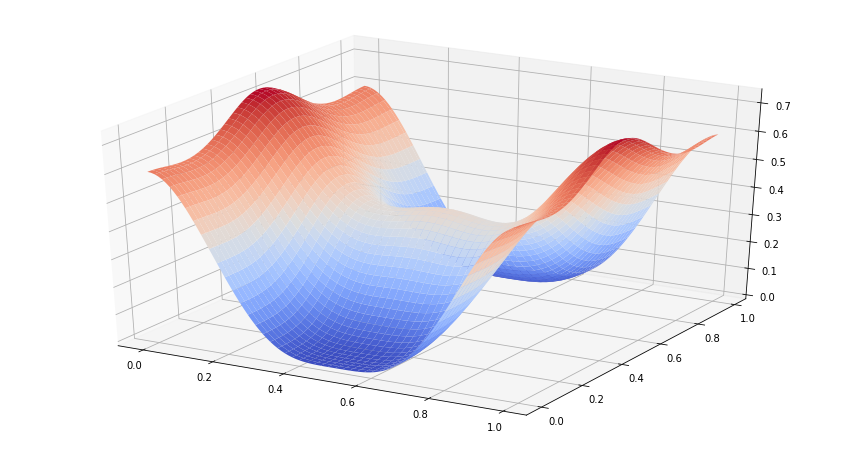

In [15]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"] = (15, 8)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm)
plt.show()